## 밤시간대 전기사용량 많은 이유?

### 다른 survey 응답 통해 확인

In [1]:
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path

# 에너지 데이터 로드
SAVE = pd.read_csv('data/SAVE/power_0428.csv', index_col=0)
SAVE = SAVE.iloc[84:,:]
SAVE.index = pd.to_datetime(SAVE.index)
SAVE[SAVE == 0] = np.nan

# 라벨 
SAVE_label = pd.read_csv('data/SAVE/save_household_survey_data_v0-3.csv', index_col = 0)
# Interviedate가 빠른 순으로 정렬
SAVE_label.sort_values('InterviewDate', inplace = True)
SAVE_label = SAVE_label.T
SAVE_label.columns = SAVE_label.columns.astype(str)

helper_dict = defaultdict(list)
for col in SAVE.columns:
    helper_dict[col[2:]].append(col)

# 동일 집끼리 병합
drop_cols = []
invalid_idx_list = []
for key,value in helper_dict.items():
    if len(value) >= 2:
        valid_idx_1 = ~pd.isnull(SAVE[value[1]])

        # replace value
        SAVE[value[0]][valid_idx_1] = SAVE[value[1]][valid_idx_1]

        # delete remain
        drop_cols.append(value[1])

# drop cols
SAVE.drop(columns = drop_cols, inplace = True)

# label과 data의 column 맞춤
SAVE.columns = [c[2:] for c in SAVE.columns]

print('Done')

Done


### Gas 보유 가정 수 확인

In [2]:
from module.util_save import matching_id

data_f, label_f = matching_id(SAVE, SAVE_label, 'Q3_6')

In [5]:
v, c = np.unique(label_f, return_counts = True)
'''
1: 보유 / main ?
2: 보유 / LPG
3. 없음
4. 모름
=> 대부분이 가스를 사용
'''
print(v)
print(c)

[1. 2. 3. 4.]
[3590   32  259   22]


### Gas가 없는 집에서도 밤시간대 사용량이 많은지?

In [15]:
# Gas
data_f, label_f = matching_id(SAVE, SAVE_label, 'Q3_6')

In [21]:
start_date = pd.to_datetime('2017-01-01 00:00:00')
end_date = pd.to_datetime('2017-02-01 23:00:00')

# dim reduct
# 가스 사용
data_1 = data_f.loc[start_date:end_date,label_f < 3].values
data_1, _ = dim_reduct(data_1, 24*4, 0)
data_1 = downsampling(data_1, 4)

# 가스 미사용
data_2 = data_f.loc[start_date:end_date,label_f == 3].values
data_2, _ = dim_reduct(data_2, 24*4, 0)
data_2 = downsampling(data_2, 4)

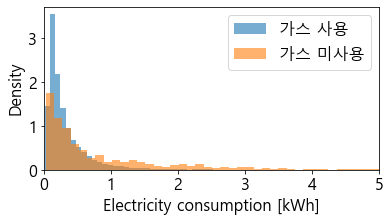

In [26]:
plt.figure(figsize = (6,3))
plt.title('')
plt.hist(data_1[:,12:18].reshape(-1), label = '가스 사용', bins = 100, alpha = 0.6, density = True)
plt.hist(data_2[:,12:18].reshape(-1), label = '가스 미사용', bins = 100, alpha = 0.6, density = True)
plt.ylabel('Density')
plt.xlabel('Electricity consumption [kWh]')
plt.legend()
plt.xlim(0, 5)
plt.show()

* 당연하지만 가스 사용 안 하는 집이 전기사용량 더 많음

### 가스 사용 안 하는 집의 사람수와의 correlation

## CER Gas 확인

In [6]:
path = 'D:/ISP/3. 데이터/ENERGY/38_CER Electricity_Gas/CER Electricity Revised March 2012/CER_Electricity_Data/'
survey_raw = pd.read_csv(path + 'Smart meters Residential pre-trial survey data.csv', encoding='cp1252', low_memory=False)
survey_raw.set_index('ID', inplace=True)
# replace blanks
for j in range(survey_raw.shape[1]):
    for i in range(survey_raw.shape[0]):
        try:
            int(survey_raw.iloc[i, j])
        except:
            survey_raw.iloc[i, j] = -1

for j in range(survey_raw.shape[1]):
    survey_raw.iloc[:, j] = survey_raw.iloc[:, j].astype(int)

In [10]:
data = survey_raw['Question 470: Which of the following best describes how you heat your: Gas']

v, c = np.unique(data, return_counts=True)
print(v)
print(c)

[0 1]
[2826 1406]


* SAVE보단 상대적으로 GAS 비율이 낮음